# Script to reproduce days based on a model trained with each individual day

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import root_mean_squared_error as rmse

from tqdm.auto import tqdm


## Datasets Preparation

In [2]:
def datasets_preparation(dataset):
    
    drivers = np.stack([np.ravel(dataset['Temperature_(0m-15m)']),
        np.ravel(dataset['Temperature_(15m-100m)']), np.ravel(dataset['Salinity_(0m-15m)']),
        np.ravel(dataset['Salinity_(15m-100m)'])])
    indx = np.where(~np.isnan(drivers).any(axis=0))
    drivers = drivers[:,indx[0]]

    diat = np.ravel(dataset['Diatom'])
    diat = diat[indx[0]]

    return(drivers, diat, indx)

## Regressor

In [3]:
def regressor (inputs, targets):
    
    inputs = inputs.transpose()
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs)
    X_train, X_test, y_train, y_test = train_test_split(inputs2, targets)

    model = MLPRegressor()
    regr = BaggingRegressor(model, n_estimators=12, n_jobs=4).fit(X_train, y_train)

    output = regr.predict(X_test)

    # compute slope m and intercept b
    m, _ = np.polyfit(y_test, output, deg=1)
    r = np.round(np.corrcoef(y_test, output)[0][1],3)
    rms = rmse(y_test, output)

    return (r, rms, m)


## Plotting 2

In [4]:
def plotting2(variable,title):
    
    fig, ax = plt.subplots()

    scatter= ax.scatter(dates,variable, marker='.', c=pd.DatetimeIndex(dates).month)

    ax.legend(handles=scatter.legend_elements()[0], labels=['February','March','April'])
    fig.suptitle('Daily ' + title + ' (15 Feb - 30 Apr)')
    
    fig.show()

## Training with the Selected Year

  0%|          | 0/1279 [00:00<?, ?it/s]

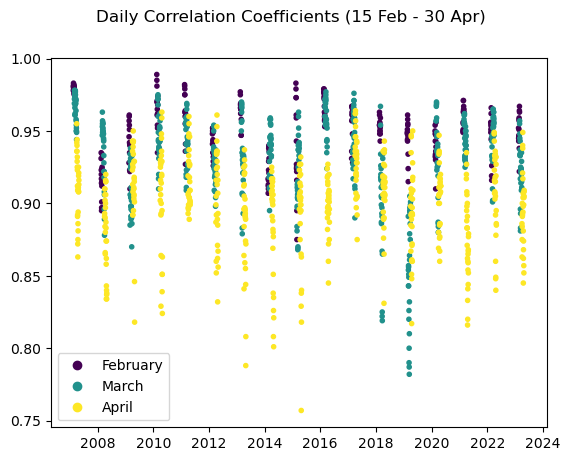

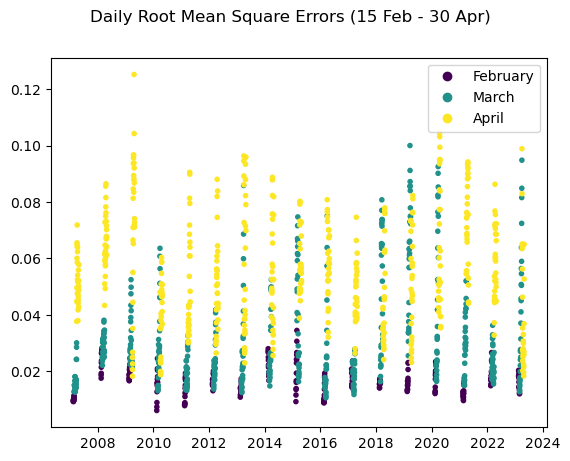

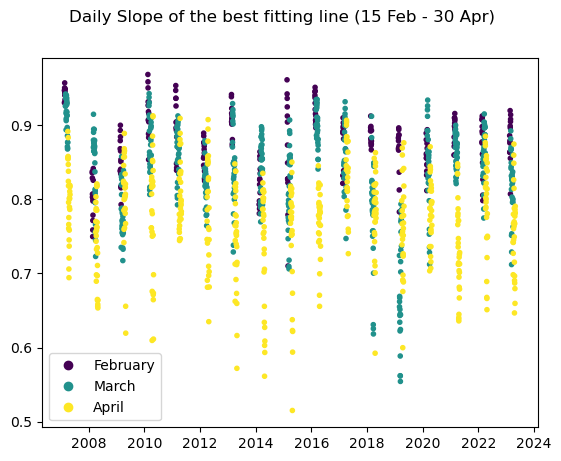

In [5]:
# Dataset and date
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
dates = pd.DatetimeIndex(ds['time_counter'].values)

# ds = ds.isel(time_counter = (np.arange(0, len(ds.Diatom.time_counter),2)), 
#     y=(np.arange(ds.y[0], ds.y[-1], 5)), 
#     x=(np.arange(ds.x[0], ds.x[-1], 5)))

r_all = []
rms_all = []
slope_all = []

for i in tqdm(range (0, len(ds.time_counter))):
    
    dataset = ds.isel(time_counter=i)

    drivers, diat, _ = datasets_preparation(dataset)

    r, rms, m = regressor(drivers, diat)

    r_all.append(r)
    rms_all.append(rms)
    slope_all.append(m)

plotting2(r_all, 'Correlation Coefficients')
plotting2(rms_all, 'Root Mean Square Errors')
plotting2(slope_all, 'Slope of the best fitting line')
